<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.stats.api as sms

import pylab as plt
import seaborn as sns

%matplotlib inline

In [2]:
cats = pd.read_csv('data/cookie_cats.csv')
cats.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
cats30 = cats.version.value_counts()
cats30

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [4]:
catret1 = cats.retention_1.value_counts()
catret1

False    50036
True     40153
Name: retention_1, dtype: int64

In [5]:
catret1 = cats.retention_7.value_counts()
catret1

False    73408
True     16781
Name: retention_7, dtype: int64

In [6]:
pd.crosstab(cats.version, cats.retention_1)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


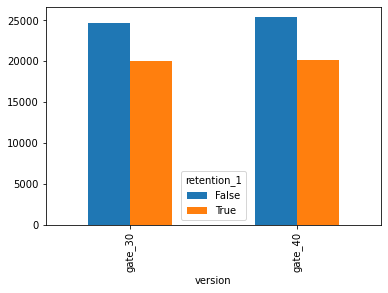

In [7]:
pd.crosstab(cats.version, cats.retention_1).plot(kind='bar');

In [8]:
control=cats[cats.version=='gate_30']

tratamiento=cats[cats.version=='gate_40']

ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,1066,gate_30,0,False,False
3,2101,gate_30,0,False,False
4,2179,gate_30,39,True,False


In [9]:
ab_test.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9998733,gate_40,10,True,False
90185,9999441,gate_40,97,True,False
90186,9999479,gate_40,30,False,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [10]:
ab_test.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [11]:
tasas_conversion=ab_test.groupby('version')['retention_1']  # agrupo por grupo



std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))



tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['retencion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')



,retencion_rate,std,std_error
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.442,0.497,0.002


### retencion_rate proporcion entre usuarios que se quedan y se van

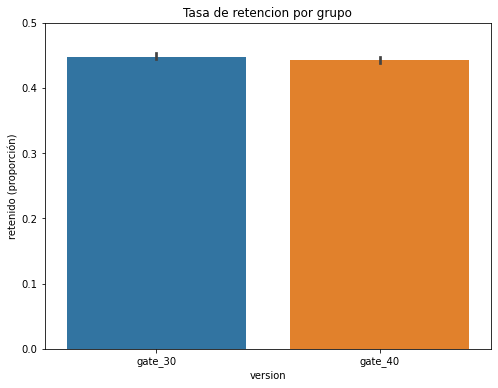

In [12]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_1'])

plt.ylim(0, 0.5)
plt.title('Tasa de retencion por grupo')
plt.xlabel('version')
plt.ylabel('retenido (proporción)');

### testear hipotesis

In [13]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


In [14]:
# seleccionar grupos

version30_res=ab_test[ab_test.version=='gate_30']['retention_1'] # nuevo dataframe filtrando la version 30 en la columna retention_1

version40_res=ab_test[ab_test.version=='gate_40']['retention_1']

In [15]:
version30_res

0        False
1         True
2        False
3        False
4         True
         ...  
44695     True
44696    False
44697     True
44698    False
44699     True
Name: retention_1, Length: 44700, dtype: bool

In [16]:
cats.shape


(90189, 5)

In [17]:
observaciones=[90189, 90189]  # count

retenciones=[version30_res.sum(), version40_res.sum()]  # conversiones por grupo


z_score, p_valor = proportions_ztest(retenciones, nobs=observaciones)

(version30_a, version40_a), (version30_b, version40_b) = proportion_confint(retenciones, 
                                                                nobs=observaciones,
                                                                alpha=0.05)

In [18]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para version 30: [{version30_a:.3f}, {version30_b:.3f}]')
print(f'intervalo conf 95% para version 40: [{version40_a:.3f}, {version40_b:.3f}]')

z-score: -0.48
p-valor: 0.630
intervalo conf 95% para version 30: [0.219, 0.225]
intervalo conf 95% para version 40: [0.220, 0.226]


###  Interpretar resultados


La hipotesis 0 = el porcentaje de retencion de la version 30 es mayor que el da la v40


Dado que el pvalor=0.63 es mayor que =0.05, no podemos rechazar la hipótesis nula , lo que significa que la v40 del 
juego no tiene una retencion significativamente diferente a la v30.

Puedo decirte con un porcetaje de confianza del 95% que la version 30 tiene una porcentaje de retencion comprendido entre...
Puedo decirte con un porcetaje de confianza del 95% que la version 40 tiene una porcentaje de retencion comprendido entre...

In [19]:

tasas_conversion

,retencion_rate,std,std_error
version,,,
gate_30,0.448188,0.497308,0.002352
gate_40,0.442283,0.496658,0.002329


In [20]:

from scipy.stats import norm

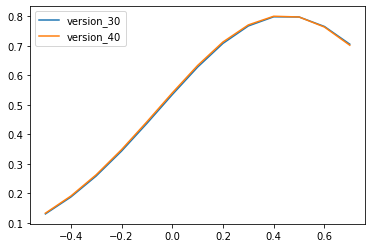

In [21]:
x=[i*.1 for i in range(-5, 8)]  

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['version_30', 'version_40']);

# retencion 7

In [22]:
tasas_conversion=ab_test.groupby('version')['retention_7']  # agrupo por grupo



std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))



tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['retencion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}')


,retencion_rate,std,std_error
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


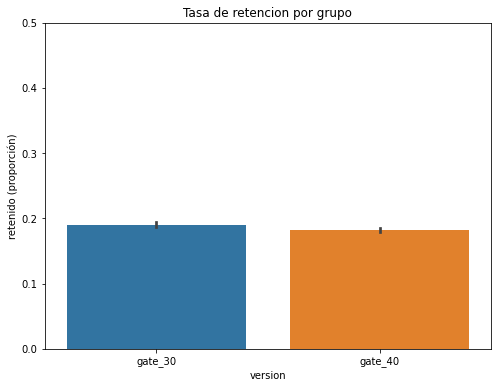

In [23]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_7'])

plt.ylim(0, 0.5)
plt.title('Tasa de retencion por grupo')
plt.xlabel('version')
plt.ylabel('retenido (proporción)');

In [24]:
# seleccionar grupos

version307_res=ab_test[ab_test.version=='gate_30']['retention_7'] # nuevo dataframe filtrando la version 30 en la columna retention_1

version407_res=ab_test[ab_test.version=='gate_40']['retention_7']

In [25]:
observaciones=[90189, 90189]  # count

retenciones=[version307_res.sum(), version407_res.sum()]  # conversiones por grupo


z_score, p_valor = proportions_ztest(retenciones, nobs=observaciones)

(version307_a, version407_a), (version307_b, version407_b) = proportion_confint(retenciones, 
                                                                nobs=observaciones,
                                                                alpha=0.05)

In [26]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para version 30: [{version307_a:.3f}, {version307_b:.3f}]')
print(f'intervalo conf 95% para version 40: [{version407_a:.3f}, {version407_b:.3f}]')

z-score: 1.81
p-valor: 0.071
intervalo conf 95% para version 30: [0.092, 0.096]
intervalo conf 95% para version 40: [0.090, 0.094]


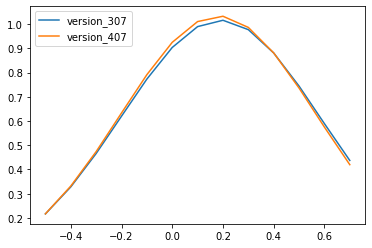

In [27]:
x=[i*.1 for i in range(-5, 8)]  

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['version_307', 'version_407']);

# TEST AB BAYES

In [ ]:
import pandas as pd

In [29]:
pd.crosstab(cats.version, cats.retention_1)

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [38]:
cats.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [44]:
cats.imps_v30, ret_v30 = 44700, 20034   # entrar, retenciones version 30
imps_v40, ret_v40= 45489, 20119 # entrar, retenciones version 40


CR_v30 = ret_v30/imps_v30
CR_v40 = ret_v40/imps_v40

f'TASAS: version30={CR_v30}, version40={CR_v40}'

'TASAS: version30=0.4404141660621249, version40=0.44228274967574577'

In [46]:
from scipy.stats import bernoulli, beta  

In [47]:
# aprioris

a_v30, b_v30 = ret_v30+1, imps_v30-ret_v30+1  # a_h0, b_h0 =  nº retenciones_h0+1 , nº impresiones_h0 - nº retencion_h0+1

a_v40, b_v40 = ret_v40+1, imps_v40-ret_v40+1  # a_h1, b_h1 = nº retenciones_h1+1 , nº impresiones_h1 - nº retencion_h1+1

beta_v30=beta(a_v30, b_v30) # IMPORTAR ESTO : from scipy.stats import bernoulli, beta  
beta_v40=beta(a_v40, b_v40)

In [48]:
beta_v30.mean(), beta_v40.mean()

(0.44041678573783827, 0.44228528719966587)

In [54]:
import bayes

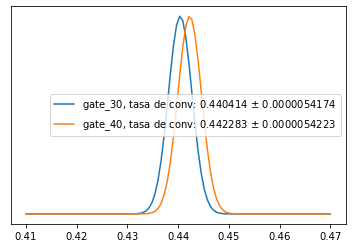

In [56]:
bayes.plot([beta_v30, beta_v40], ['gate_30', 'gate_40'], linf=0.41, lsup=0.47)

In [ ]:
# salto=(beta_test.mean() - beta_control.mean())/beta_control.mean()

# salto

In [60]:
salto=(beta_v40.mean() - beta_v30.mean())/beta_v30.mean()

salto

0.004242575492887412

In [58]:
%pip install mpmath

from mpmath import betainc   # integral de beta

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# bayes.calc_prob(beta_control, beta_test)

In [61]:
bayes.calc_prob(beta_v30, beta_v40)

0.2851791120536727

In [62]:
prob=betainc(a_v40, b_v40, 0.28, 1, regularized=True) # utilizar version nueva/test/v40

prob=float(prob)

prob

NoConvergence: Hypergeometric series converges too slowly. Try increasing maxterms.